### 라이브러리 버전 확인 및 데이터 준비

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/drive")
from PIL import Image
import glob
import numpy as np
from tensorflow import keras

Mounted at /content/drive


### 데이터 불러오기 + Resize 하기

---
기존 파일 사이즈 : 224 x 224 pix   
-> 데이터 사이즈 28 x 28로 변경하기위해 PIL 라이브러리 사용

In [4]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = '/content/drive/MyDrive/COLAB_data/scissor'
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

737  images to be resized.
737  images resized.
가위 이미지 resize 완료!


In [ ]:
image_dir_path_r = '/content/drive/MyDrive/COLAB_data/rock'
resize_images(image_dir_path_r)
print("바위 이미지 resize 완료!")
image_dir_path_p = '/content/drive/MyDrive/COLAB_data/paper'
resize_images(image_dir_path_p)
print("보 이미지 resize 완료!")

200  images to be resized.
200  images resized.
바위 이미지 resize 완료!
200  images to be resized.
200  images resized.
보 이미지 resize 완료!


이미지의 사이즈를 변경하였으니, 이제 학습시키기 위해서 데이터에 라벨링을 해보자.

In [ ]:
def load_data(img_path, number_of_data=610):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = '/content/drive/MyDrive/COLAB_data'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 610 입니다.
x_train shape: (610, 28, 28, 3)
y_train shape: (610,)


어디 이미지에 라벨링이 잘 되었는지 확인해보자.

라벨:  0


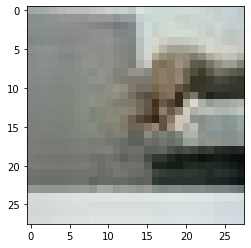

In [ ]:
#가위
plt.imshow(x_train[209])
print('라벨: ', y_train[209])

라벨:  1


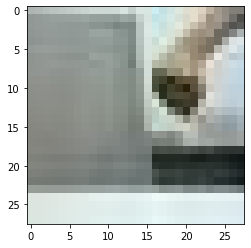

In [ ]:
#바위
plt.imshow(x_train[409])
print('라벨: ', y_train[409])

라벨:  2


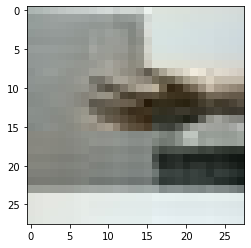

In [ ]:
#보
plt.imshow(x_train[609])
print('라벨: ', y_train[609])

라벨링은 잘 되어졌고 255로 나눠 정규화도 시켜주었으니, 이제 학습을 시키기 위한 단계를 진행해보자

### 딥러닝 네트워크 설계하기

**Sequential Model 사용**

우선 이미지 특징수는 나중에 수정할 수 있으니 먼저는 기존과 동일하게 테스트를 진행해보도록하자.   

그리고 흑백 -> 컬러로 바뀌었으니, input_shape=(28,28,3)으로 변경하고  
마지막 Dense의 수를 3(가위, 바위, 보)로 수정해준다.

In [ ]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                2

이제 모델 설계를 마쳤으니, 학습시켜보도록 하자!

### 딥러닝 네트워크 학습시키기  

데이터 갯수가 별로 없으니 epoch를 15로 살짝 늘려보자

In [ ]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=15)

Epoch 1/15
20/20 [==============================] - 11s 5ms/step - loss: 5.9395 - accuracy: 0.4361
Epoch 2/15
20/20 [==============================] - 0s 4ms/step - loss: 0.9350 - accuracy: 0.6934
Epoch 3/15
20/20 [==============================] - 0s 4ms/step - loss: 0.4568 - accuracy: 0.8295
Epoch 4/15
20/20 [==============================] - 0s 4ms/step - loss: 0.2336 - accuracy: 0.9131
Epoch 5/15
20/20 [==============================] - 0s 4ms/step - loss: 0.1363 - accuracy: 0.9541
Epoch 6/15
20/20 [==============================] - 0s 4ms/step - loss: 0.1120 - accuracy: 0.9590
Epoch 7/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0566 - accuracy: 0.9869
Epoch 8/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0307 - accuracy: 1.0000
Epoch 9/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0246 - accuracy: 0.9984
Epoch 10/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0148 - accuracy: 1.0000
Epoch 11/15
20/20 

10번 이후로는 다 정확도가 1.00이 나오는 것을 보아, epoch는 12번 정도로 줄여보자.  

### 테스트 데이터 입력 후 비교하기

In [ ]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path_test_s = '/content/drive/MyDrive/COLAB_data/rsp_test/scissor'
resize_images(image_dir_path_test_s)

print("가위 이미지 resize 완료!")

image_dir_path_test_r = '/content/drive/MyDrive/COLAB_data/rsp_test/rock'
resize_images(image_dir_path_test_r)

print("바위 이미지 resize 완료!")

image_dir_path_test_p = '/content/drive/MyDrive/COLAB_data/rsp_test/paper'
resize_images(image_dir_path_test_p)

print("보 이미지 resize 완료!")


527  images to be resized.
527  images resized.
가위 이미지 resize 완료!
553  images to be resized.
553  images resized.
바위 이미지 resize 완료!
623  images to be resized.
623  images resized.
보 이미지 resize 완료!


In [ ]:
def load_data_test(img_path_test, number_of_data=1703):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path_test+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path_test+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path_test+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path_test = '/content/drive/MyDrive/COLAB_data/rsp_test'
(x_test, y_test)=load_data_test(image_dir_path_test)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 1703 입니다.
x_test shape: (1703, 28, 28, 3)
y_test shape: (1703,)


이제 테스트 자료도 변환하여 넣어주었으니, 학습된 모델에 넣어 돌려보자....! 두근....   
테스트 데이터에 비해 트래이닝 데이터 갯수가 부족해 조금 염려가 되긴 하지만 우선 고!

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

54/54 - 0s - loss: 4.4627 - accuracy: 0.3699 - 326ms/epoch - 6ms/step
test_loss: 4.462664604187012 
test_accuracy: 0.36993539333343506


ㅋㅋㅋㅋㅋㅋ 정확도의 결과가 0.369로 거의 찍은것과 비슷한 결과가 나왔다...ㅎ..ㅎ.ㅎ.ㅎ.ㅎㅎㅎㅎ  

뭐 예상한 결과니 우선 어떤 데이터를 잘못추론했는지 확인해보자.  

원래는 사이즈 조정 후 그림이 너무 뭉개져서, 학습 모델의 인자를 확대해 테스트 자료와 다시 비교해볼 예정이었는데, 트래이닝 데이터의 갯수가 많이 부족한 것 같아 현재 사용한 test 데이터를 train에 추가하여 학습을 좀더 진행한 후 다시 테스트를 진행해보자.   

**이후 방향**   
1) train 데이터 갯수 동일, 특성 인자 확대, 재학습  
2) train 데이터 갯수 증가, 특성 인자 동일, 재학습  
3) train 데이터 갯수 증가, 특성 인자 확대, 재학습  


model.predict() 결과 :  [0.09974117 0.01086822 0.88939065]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


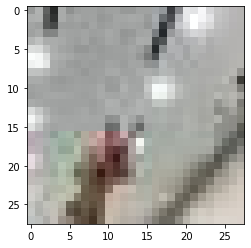

In [ ]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

model.predict() 결과 :  [6.771579e-04 7.074218e-05 9.992520e-01]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


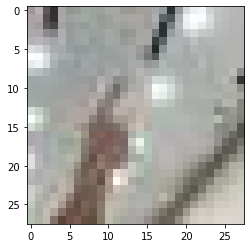

In [ ]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=55  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

확실히 데이터가 많이 뭉게져서,, 사람인 나도 자세히 뜯어봐야 알 수 있을 것 같으니... 특성 인자를 확대해보자.  



### 1) train 데이터 갯수 동일, 특성 인자 확대, 재학습  

---

- n_channel : 2배 증가
- dense : 2배 증가 
- epoch : 15 고정  
(앞서 진행했을 때, epoch가 10정도 지났을 때 정확도가 1이 나와 12를 할까 했으나... 혹시 모르니 15로 고정하기로함)

In [ ]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (

- 0 ; 기존 테스트 당시  
Total params: 30,819  
Trainable params: 30,819  
Non-trainable params: 0  

- 1차 재시도 ; 
Total params: 242,947  
Trainable params: 242,947  
Non-trainable params: 0  

Params가 거의 8배정도 증가한 것을 볼 수 있다.  
과연 그 결과는...?

In [ ]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=15)

Epoch 1/15
20/20 [==============================] - 1s 8ms/step - loss: 30.6767 - accuracy: 0.3475
Epoch 2/15
20/20 [==============================] - 0s 7ms/step - loss: 1.6484 - accuracy: 0.4885
Epoch 3/15
20/20 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.7361
Epoch 4/15
20/20 [==============================] - 0s 4ms/step - loss: 0.1198 - accuracy: 0.9721
Epoch 9/15
20/20 [==============================] - 0s 4ms/step - loss: 0.1069 - accuracy: 0.9770
Epoch 10/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0647 - accuracy: 0.9934
Epoch 11/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.9967
Epoch 12/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0329 - accuracy: 0.9984
Epoch 13/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0270 - accuracy: 1.0000
Epoch 14/15
20/20 [==============================] - 0s 4ms/step - loss: 0.0194 - accuracy: 1.0000
Epoch 15/15
20

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

54/54 - 0s - loss: 3.6282 - accuracy: 0.3911 - 274ms/epoch - 5ms/step
test_loss: 3.628204584121704 
test_accuracy: 0.3910745680332184


- **test_accuracy 변화 : 0.022증가**
    + 기존: 0.369
    + 1차 : 0.39107

### 2) train 데이터 갯수 증가, 특성 인자 동일, 재학습

---
- train 데이터 기존 : 610
- train 데이터 증가 후 : 2,353 (+1,703)
- 특성인자 동일진행

- test 데이터는 신규 데이터 입력 예정

In [ ]:
image_dir_path = '/content/drive/MyDrive/COLAB_data/scissor'
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

image_dir_path_r = '/content/drive/MyDrive/COLAB_data/rock'
resize_images(image_dir_path_r)
print("바위 이미지 resize 완료!")

image_dir_path_p = '/content/drive/MyDrive/COLAB_data/paper'
resize_images(image_dir_path_p)
print("보 이미지 resize 완료!")

737  images to be resized.
737  images resized.
가위 이미지 resize 완료!
753  images to be resized.
753  images resized.
바위 이미지 resize 완료!
863  images to be resized.
863  images resized.
보 이미지 resize 완료!


In [10]:
def load_data(img_path, number_of_data=2353):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = '/content/drive/MyDrive/COLAB_data'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 2353 입니다.
x_train shape: (2353, 28, 28, 3)
y_train shape: (2353,)


In [11]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (

In [15]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=15)

Epoch 1/15
74/74 [==============================] - 1s 3ms/step - loss: 0.0249 - accuracy: 0.9911
Epoch 2/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0421 - accuracy: 0.9885
Epoch 3/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0971 - accuracy: 0.9703
Epoch 4/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0780 - accuracy: 0.9771
Epoch 5/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0318 - accuracy: 0.9864
Epoch 6/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0247 - accuracy: 0.9911
Epoch 7/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0057 - accuracy: 0.9992
Epoch 8/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0061 - accuracy: 0.9979
Epoch 9/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0249 - accuracy: 0.9924
Epoch 10/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9945
Epoch 11/15
74/74 [

정확도가 1.0으로 좋은 수치를 나타내고 있다.   
그럼 신규 테스트 데이터를 넣어보자

In [ ]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path_test_s = '/content/drive/MyDrive/COLAB_data/rsp_test/scissor'
resize_images(image_dir_path_test_s)

print("가위 이미지 resize 완료!")

image_dir_path_test_r = '/content/drive/MyDrive/COLAB_data/rsp_test/rock'
resize_images(image_dir_path_test_r)

print("바위 이미지 resize 완료!")

image_dir_path_test_p = '/content/drive/MyDrive/COLAB_data/rsp_test/paper'
resize_images(image_dir_path_test_p)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
101  images to be resized.
101  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


In [ ]:
def load_data_test(img_path_test, number_of_data=301):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path_test+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path_test+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path_test+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path_test = '/content/drive/MyDrive/COLAB_data/rsp_test'
(x_test, y_test)=load_data_test(image_dir_path_test)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 301 입니다.
x_test shape: (301, 28, 28, 3)
y_test shape: (301,)


In [ ]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 21.2337 - accuracy: 0.2525 - 177ms/epoch - 18ms/step
test_loss: 21.233732223510742 
test_accuracy: 0.25249168276786804


**test_accuracy 변화 : 0.011감소**  
기존: 0.369  
2차 : 0.25249

음...? 정확도가 0.25249로 오히려 찍으니만 못하다...?  
게다가 기존보다 떨어졌다...?  
왜이런 결과가 나온거지...?  
흠........  

우선 3번째를 진행해보고 다시 생각해보도록하자...


### 3) train 데이터 갯수 증가, 특성 인자 확대, 재학습  

---

- train 데이터 증가 : 2,353 
- n_channel : 2배 증가
- dense : 2배 증가 
- epoch : 15 고정  
(앞서 진행했을 때, epoch가 10정도 지났을 때 정확도가 1이 나와 12를 할까 했으나... 혹시 모르니 15로 고정하기로함) 

In [8]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (No

In [16]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=15)

Epoch 1/15
74/74 [==============================] - 1s 3ms/step - loss: 0.0392 - accuracy: 0.9864
Epoch 2/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0191 - accuracy: 0.9949
Epoch 3/15
74/74 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 4/15
74/74 [==============================] - 0s 3ms/step - loss: 6.3728e-04 - accuracy: 1.0000
Epoch 5/15
74/74 [==============================] - 0s 3ms/step - loss: 2.7141e-04 - accuracy: 1.0000
Epoch 6/15
74/74 [==============================] - 0s 3ms/step - loss: 2.2823e-04 - accuracy: 1.0000
Epoch 7/15
74/74 [==============================] - 0s 3ms/step - loss: 2.0148e-04 - accuracy: 1.0000
Epoch 8/15
74/74 [==============================] - 0s 3ms/step - loss: 1.7385e-04 - accuracy: 1.0000
Epoch 9/15
74/74 [==============================] - 0s 3ms/step - loss: 1.6961e-04 - accuracy: 1.0000
Epoch 10/15
74/74 [==============================] - 0s 3ms/step - loss: 1.5067e-04 - accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 6.8092 - accuracy: 0.3920 - 165ms/epoch - 16ms/step
test_loss: 6.809207916259766 
test_accuracy: 0.3920265734195709


**test_accuracy 변화 : 0.03 증가**  
기존: 0.369  
3차 : 0.392  

소폭 증가하였지만 정확도가 약 0.4로 무작위로 골랐을 때 확률이 0.3333 인것을 감안하였을 때, 생각보다 미비한 값으로 생각된다.   

그래도 확실히 데이터의 갯수를 늘리고, 특성들을 올려 좀 더 자세히 보니 정확도가 증가하는 것을 확인하였다.  

여기서 더 욕심을 내서 정확도를 올리고자한다면, 데이터와 특성들을 더 강화하면 가능할 것 같다.  

### 4) train 데이터 갯수 증가, 특성 인자 확대, 재학습 후 test 데이터 갯수 증가  

---
- test 데이터 증가 : 600 (+310)
- train 데이터 증가 : 2,353 
- n_channel : 2배 증가
- dense : 2배 증가 
- epoch : 15 고정  

In [5]:
def load_data(img_path, number_of_data=610):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [23]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path_test_s = '/content/drive/MyDrive/COLAB_data/rsp_test/scissor'
resize_images(image_dir_path_test_s)

print("가위 이미지 resize 완료!")

image_dir_path_test_r = '/content/drive/MyDrive/COLAB_data/rsp_test/rock'
resize_images(image_dir_path_test_r)

print("바위 이미지 resize 완료!")

image_dir_path_test_p = '/content/drive/MyDrive/COLAB_data/rsp_test/paper'
resize_images(image_dir_path_test_p)

print("보 이미지 resize 완료!")

180  images to be resized.
180  images resized.
가위 이미지 resize 완료!
181  images to be resized.
181  images resized.
바위 이미지 resize 완료!
182  images to be resized.
182  images resized.
보 이미지 resize 완료!


In [24]:
def load_data_test(img_path_test, number_of_data=543):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path_test+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path_test+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path_test+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path_test = '/content/drive/MyDrive/COLAB_data/rsp_test'
(x_test, y_test)=load_data_test(image_dir_path_test)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 543 입니다.
x_test shape: (543, 28, 28, 3)
y_test shape: (543,)


In [26]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

17/17 - 0s - loss: 12.9301 - accuracy: 0.4530 - 46ms/epoch - 3ms/step
test_loss: 12.930073738098145 
test_accuracy: 0.45303866267204285


## 회고 

---

- `import` 줄을 계속 실행되지 않도록 위쪽에 배치하는 방법을 알았다. 이후에도 위쪽에 몰아서 넣고 좀 더 가볍게 실행되도록 해야겠다.  
- 그리고 이미지 처리하는 것을 처음 해봤는데, 전처리하고 특성들을 변경해보면서 test accuracy가 변화하는 모습을 보는게 신기했다. 이후엔 좀 더 화상도가 높은 사진을 처리하면서 정확도를 올리고 싶다.  
- 이번 Ex를 진행하면서 컴퓨터를 똑순이라고생각했는데, 가벼운 데이터인데도 돌릴 때 마다 값이 변하는 것을 보면서 왜 DL이 운빨이라고하는지 알 것 같았고 마냥 똑순이는 아닌것 같다... 다를 생각이 들었다. 이놈아 넌 컴퓨터잖오....!!!  
- 마지막 데이터의 loss 값과 test 값의 정확도를 그래프로 시각화 해보고싶은데 코드를 찾지 못해 슬프다.. 
- 그리고 마지막 정확도가 0.45까지 올리긴 했는데,,, 이번에 사용한 훈련코드가 약해서 그런지 정확도가 많이 올라가지 못해 아쉽다. 